# Your first convolutional neural network

# imports

In [1]:
import numpy as np

from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K 

from keras.datasets import cifar10

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

2022-12-26 15:13:14.477604: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# data

In [2]:
NUM_CLASSES = 10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

In [5]:
x_train[54, 12, 13, 1] 

0.36862746

# architecture

In [6]:
input_layer = Input(shape=(32,32,3))

conv_layer_1 = Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2
    , padding = 'same'
    )(input_layer)

conv_layer_2 = Conv2D(
    filters = 20
    , kernel_size = (3,3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)

flatten_layer = Flatten()(conv_layer_2)

output_layer = Dense(units=10, activation = 'softmax')(flatten_layer)

model = Model(input_layer, output_layer)

2022-12-26 16:11:25.811091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 10)        490       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 20)          1820      
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 15,120
Trainable params: 15,120
Non-trainable params: 0
_________________________________________________________________


In [8]:
input_layer = Input((32,32,3))

x = Conv2D(filters = 32, kernel_size = 3, strides = 1, padding = 'same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 32, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)


x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.5)(x)

x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)

In [9]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       128       
 hNormalization)                                           

## pytorch Model

In [125]:
from collections import OrderedDict

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding="same"):
        super().__init__()
        self.conv_stack = nn.Sequential(
            OrderedDict([
                ("conv", nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)),
                ("batch_norm", nn.BatchNorm2d(out_channels)),
                ("leaky_relu", nn.LeakyReLU(0.3)),
            ])
        )
    
    def forward(self, x):
        out = self.conv_stack(x)
        return out

class PytorchModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(3, 32, 3, 1, "same")
        self.conv2 = ConvLayer(32, 32, 2, 2, 0)
        self.conv3 = ConvLayer(32, 64, 3, 1, "same")
        self.conv4 = ConvLayer(64, 64, 2, 2, 0)
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(4096, 128)
        self.bnd1 = nn.BatchNorm1d(128)
        self.actd1 = nn.LeakyReLU(0.3)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(128, 10)
        self._initialize_weights()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.flat1(out)
        out = self.dense1(out)
        out = self.bnd1(out)
        out = self.actd1(out)
        out = self.drop1(out)
        out = self.dense2(out)
        out = nn.functional.softmax(out, dim=1)
        return out
    
    def _initialize_weights(self):
        with torch.no_grad():
            self.apply(self.init_weights)
                
    @staticmethod
    def init_weights(layer):
        if type(layer) == ConvLayer:
            return
        elif type(layer) in [nn.BatchNorm1d, nn.BatchNorm2d]:
            layer.weight.data.fill_(1.0)
            layer.bias.data.fill_(0.0)
        else:
            if hasattr(layer, "weight"):
                torch.nn.init.xavier_uniform_(layer.weight)

            if hasattr(layer, "bias"):
                layer.bias.data.fill_(0.0)
            
    def fit(self, X, y, learning_rate=0.0005, batch_size=32, epochs=10, shuffle=True):
        optimizer = torch.optim.Adam(lr=learning_rate, params=self.parameters())
        dataset = TensorDataset(X, y)
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
        )

        loss_fn = nn.NLLLoss(reduction="sum")
        for epoch in range(1, epochs + 1):
            n, total_loss = 0, 0.0
            for obs, labels in train_loader:
                outputs = self(obs)
                loss = loss_fn(torch.log(outputs), labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                n += outputs.shape[0]
                total_loss += float(loss.item())
                
            avg_loss = 1.0 * total_loss / n
            print(f"Epoch {epoch} Loss: {avg_loss:.6f}")
        
        return self

# train

In [73]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

/Users/benjamincross/miniconda3/envs/GDL/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [74]:
model.fit(x_train
          , y_train
          , batch_size=32
          , epochs=10
          , shuffle=True
          , validation_data = (x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 164s 104ms/step - loss: 1.5481 - accuracy: 0.4589 - val_loss: 1.2519 - val_accuracy: 0.5682
Epoch 2/10
1563/1563 [==============================] - 156s 100ms/step - loss: 1.1427 - accuracy: 0.5993 - val_loss: 1.0730 - val_accuracy: 0.6225
Epoch 3/10
1563/1563 [==============================] - 161s 103ms/step - loss: 0.9965 - accuracy: 0.6521 - val_loss: 1.0072 - val_accuracy: 0.6418
Epoch 4/10
1563/1563 [==============================] - 162s 104ms/step - loss: 0.9186 - accuracy: 0.6795 - val_loss: 0.9041 - val_accuracy: 0.6870
Epoch 5/10
1563/1563 [==============================] - 164s 105ms/step - loss: 0.8520 - accuracy: 0.7028 - val_loss: 0.8980 - val_accuracy: 0.6850
Epoch 6/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.8055 - accuracy: 0.7185 - val_loss: 0.8544 - val_accuracy: 0.7051
Epoch 7/10
1563/1563 [==============================] - 167s 107ms/step - loss: 0.7528 - accuracy: 0.7353 - val_

In [75]:
model.layers[6].get_weights()

[]

## Train PyTorch Model

In [126]:
pytorch_model = PytorchModel()
x_train_pytorch = torch.from_numpy(x_train).type(torch.float32)
x_train_pytorch = torch.permute(x_train_pytorch, [0, 3, 1, 2])
y_train_pytorch = torch.from_numpy(y_train_index).squeeze(-1).type(torch.LongTensor)
pytorch_model.fit(
    x_train_pytorch, 
    y_train_pytorch,
)

Epoch 1 Loss: 1.569258
Epoch 2 Loss: 1.180938
Epoch 3 Loss: 1.032060
Epoch 4 Loss: 0.950461
Epoch 5 Loss: 0.885206
Epoch 6 Loss: 0.832706
Epoch 7 Loss: 0.791788
Epoch 8 Loss: 0.745299
Epoch 9 Loss: 0.713811
Epoch 10 Loss: 0.687601


PytorchModel(
  (conv1): ConvLayer(
    (conv_stack): Sequential(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.3)
    )
  )
  (conv2): ConvLayer(
    (conv_stack): Sequential(
      (conv): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2))
      (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.3)
    )
  )
  (conv3): ConvLayer(
    (conv_stack): Sequential(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.3)
    )
  )
  (conv4): ConvLayer(
    (conv_stack): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
      (batch_no

In [129]:
pytorch_model.eval();

In [130]:
pytorch_model(x_train_pytorch[:10])

tensor([[3.5637e-06, 3.2782e-07, 4.6220e-03, 3.9505e-02, 2.6211e-03, 5.4364e-03,
         9.4776e-01, 3.2918e-05, 1.9248e-05, 6.2599e-07],
        [2.7276e-06, 2.8434e-04, 1.1364e-05, 5.1857e-06, 4.1983e-06, 9.2818e-06,
         1.9857e-08, 8.2594e-05, 1.1732e-05, 9.9959e-01],
        [2.9840e-03, 5.8379e-02, 3.8758e-03, 5.2734e-04, 4.5264e-05, 1.5762e-03,
         2.7694e-04, 3.6327e-03, 4.0577e-03, 9.2465e-01],
        [5.4490e-06, 2.9065e-05, 2.8365e-04, 2.0855e-03, 9.8140e-01, 1.2717e-03,
         1.4833e-02, 7.7477e-05, 3.6666e-06, 1.0082e-05],
        [3.7625e-02, 8.2730e-01, 2.5315e-05, 1.2888e-06, 1.4964e-04, 1.3344e-06,
         1.6158e-06, 3.8821e-04, 1.3556e-02, 1.2095e-01],
        [2.6592e-05, 9.9134e-01, 3.8143e-05, 1.8058e-04, 1.1977e-05, 2.6949e-04,
         3.2695e-03, 9.8941e-05, 1.3757e-04, 4.6289e-03],
        [2.8354e-03, 3.4590e-04, 6.5570e-01, 2.8056e-02, 1.9429e-01, 5.0421e-03,
         1.0717e-01, 4.3872e-03, 4.7326e-05, 2.1292e-03],
        [9.4369e-08, 3.3368

# analysis

In [114]:
model.evaluate(x_test, y_test, batch_size=1000)

10/10 [==============================] - 6s 589ms/step - loss: 0.7857 - accuracy: 0.7306


[0.7857456803321838, 0.7305999994277954]

In [115]:
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis = -1)]
actual_single = CLASSES[np.argmax(y_test, axis = -1)]

313/313 [==============================] - 9s 27ms/step


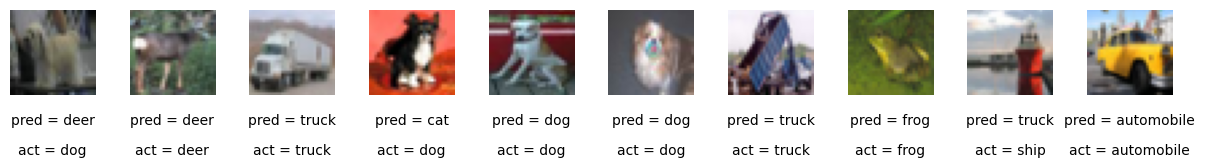

In [116]:
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)


## Evaluate pytorch model

In [131]:
pytorch_x_test = torch.from_numpy(x_test).to(torch.float32)
pytorch_x_test = torch.permute(pytorch_x_test, [0, 3, 1, 2])
y_test_index = np.argmax(y_test, axis=1)
pytorch_y_test = torch.from_numpy(y_test_index).squeeze(-1).to(torch.float32)
preds = pytorch_model(pytorch_x_test)
pred_classes = CLASSES[torch.argmax(preds, axis=-1)]

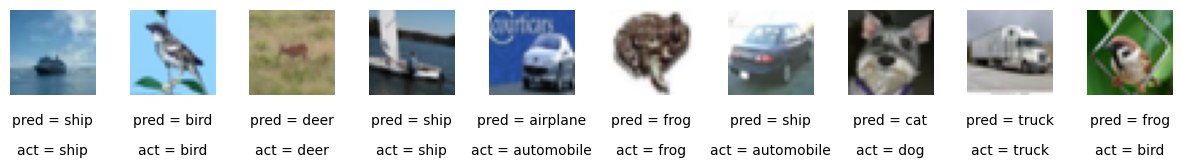

In [132]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(pred_classes[idx]), fontsize=10, ha='center', transform=ax.transAxes) 
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

In [133]:
print("Accuracy: {:.4f}".format((pred_classes == actual_single).mean()))

Accuracy: 0.7194


In [134]:
t = torch.randn(4, 3)
nn.functional.softmax(t, dim=0)

tensor([[0.0448, 0.2931, 0.0378],
        [0.8648, 0.0590, 0.1467],
        [0.0289, 0.0505, 0.7457],
        [0.0615, 0.5973, 0.0698]])